In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 




import json



In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
model_conf = confs.roberta_conf
encoding_type = 'brk'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_roberta_about_brk'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.5102040816326531
MALE 0.0
FEMALE 1.0 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.4810606060606061
MALE 0.0
FEMALE 1.0 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.48370273794002605
MALE 0.0
FEMALE 1.0 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6859272563706708 	 Validation loss: 0.6837021971153001 	 
  1%|          | 574/57400 [01:21<2:18:13,  6.85it/s]
Epoch 2 	 Training loss: 0.6822198496462991 	 Validation loss: 0.6835587186328436 	 
  2%|▏         | 1148/57400 [02:57<2:05:41,  7.46it/s]
Epoch 3 	 Training loss: 0.6812512052183782 	 Validation loss: 0.6829241776870469 	 
  3%|▎         | 1722/57400 [04:33<2:19:40,  6.64it/s]
Epoch 4 	 Training loss: 0.6804073071853625 	 Validation loss: 0.6821772355144307 	 
  4%|▍         | 2296/57400 [06:09<2:22:18,  6.45it/s]
Epoch 5 	 Training loss: 0.6787158299613912 	 Validation loss: 0.6801627136893191 	 
  5%|▌         | 2870/57400 [07:45<2:26:29,  6.20it/s]
Epoch 6 	 Training loss: 0.6727355637616812 	 Validation loss: 0.6618410722684052 	 
  6%|▌         | 3444/57400 [09:21<2:20:34,  6.40it/s]
Epoch 7 	 Training loss: 0.5653923884916804 	 Validation loss: 0.45315004354816374 	 
  7%|▋         | 4018/57400 [10:56<2:24:52,  6.14it/s]
Epoch 8 	 Training l

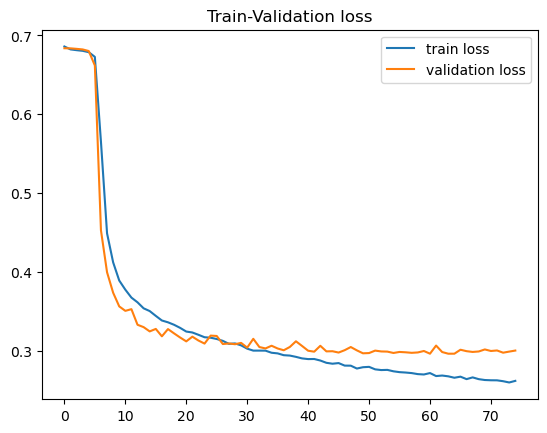

In [17]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.8635204081632653
MALE 0.875
FEMALE 0.8525 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.6919191919191919
MALE 0.7128953771289538
FEMALE 0.6692913385826772 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.6883963494132985
MALE 0.7146464646464646
FEMALE 0.660377358490566 



# TO

In [15]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_roberta_to_brk'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6942615484111401 	 Validation loss: 0.693470756886369 	 
  1%|          | 574/57400 [01:19<2:09:56,  7.29it/s]
Epoch 2 	 Training loss: 0.6935176616761742 	 Validation loss: 0.6926593719902685 	 
  2%|▏         | 1148/57400 [02:38<1:48:15,  8.66it/s]
Epoch 3 	 Training loss: 0.6934332689757131 	 Validation loss: 0.6937301290237298 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [03:57<1:55:04,  8.06it/s]
Epoch 4 	 Training loss: 0.69346249331996 	 Validation loss: 0.6927775275909295 	 
  4%|▍         | 2296/57400 [05:17<2:06:21,  7.27it/s]
Epoch 5 	 Training loss: 0.6934282907417842 	 Validation loss: 0.6924555584535761 	 
  5%|▌         | 2870/57400 [06:37<2:01:43,  7.47it/s]
Epoch 6 	 Training loss: 0.693372455000462 	 Validation loss: 0.6936161538301888 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [07:56<1:51:55,  8.03it/s]
Epoch 7 	 Training loss: 0.6933199030181673 	 Validation loss: 0.6931843565682233 	 
  7%|▋         | 4018/

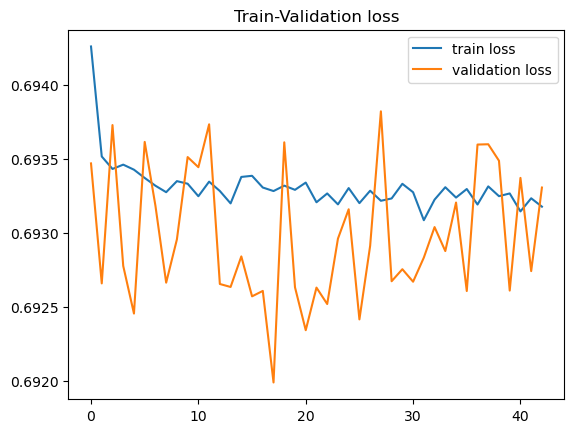

In [16]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [17]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.5051020408163265
MALE 0.0026041666666666665
FEMALE 0.9875 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.4772727272727273
MALE 0.004866180048661801
FEMALE 0.9868766404199475 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.48370273794002605
MALE 0.022727272727272728
FEMALE 0.9757412398921833 



# AS

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_roberta_as_brk'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6935585387284747 	 Validation loss: 0.6930940919003244 	 
  1%|          | 574/57400 [01:18<1:55:05,  8.23it/s]
Epoch 2 	 Training loss: 0.6934400507174302 	 Validation loss: 0.6930750224549892 	 
  2%|▏         | 1148/57400 [02:37<2:05:07,  7.49it/s]
Epoch 3 	 Training loss: 0.693545953529637 	 Validation loss: 0.6928897055528932 	 
  3%|▎         | 1722/57400 [03:56<2:03:05,  7.54it/s]
Epoch 4 	 Training loss: 0.6935135814578691 	 Validation loss: 0.6926078018495592 	 
  4%|▍         | 2296/57400 [05:16<2:33:42,  5.98it/s]
Epoch 5 	 Training loss: 0.6934799901907452 	 Validation loss: 0.6925430691848367 	 
  5%|▌         | 2870/57400 [06:34<1:44:00,  8.74it/s]
Epoch 6 	 Training loss: 0.6933255402260956 	 Validation loss: 0.6926154827667494 	 
  6%|▌         | 3444/57400 [07:53<2:04:49,  7.20it/s]
Epoch 7 	 Training loss: 0.6935176507728856 	 Validation loss: 0.6929892341969377 	 
  7%|▋         | 4018/57400 [09:11<1:52:08,  7.93it/s]
Epoch 8 	 Training los

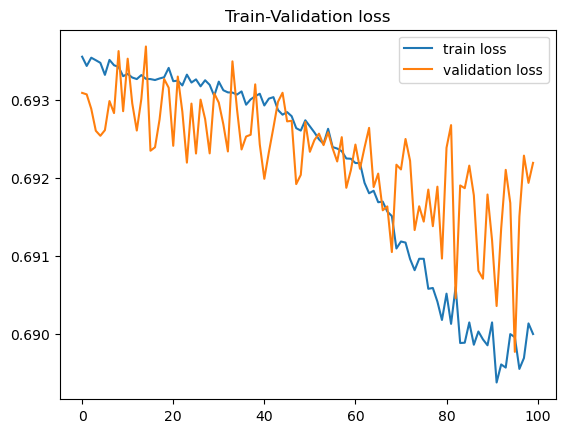

In [19]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [22]:
save_path='m1_dep_roberta_as_brk'
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.7283163265306123
MALE 0.6953125
FEMALE 0.76 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.6957070707070707
MALE 0.6593673965936739
FEMALE 0.7349081364829396 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.6910039113428944
MALE 0.6085858585858586
FEMALE 0.7789757412398922 

